<a href="https://colab.research.google.com/github/LaraN01/DrugData_AdverseEvents/blob/main/Notebook_4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import the libraries

In [1]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import multiprocessing
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline


# 2. Load the data

In [5]:
# To activate when running on colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#dataset_path = '/content/drive/MyDrive/CAS_2023/final_dataset.csv'
#dataset_path = r"C:\Users\herzr\Desktop\Gitignore\final_dataset.csv"
dataset_path='datasets/final_dataset.csv'

In [7]:
data=pd.read_csv(dataset_path,index_col=0, dtype={
    'UNII Codes for Inactive Ingredients':'O',
    'UNII Codes for Active Ingredients':'O',
    'Routes of Administration':'O',
    'Product Types':'O',
    'charge':'f4',
    'count':'f4',
    'stereochemistry':'O',
    'defined_stereo':'f4',
    'ez_centers':'f4',
    'molecular_weight':'f4',
    'optical_activity':'O',
    'stereo_centers':'f4',
    'patientsex':'O',
    'risk score':'f4'} )

# 3. Prepare the dataset

There is three product types: 'HUMAN PRESCRIPTION DRUG', 'HUMAN OTC DRUG', 'CELLULAR THERAPY'.
To select a different one change the target entry in the corresponing field of the loading function below.

Route of administration has as well fifferent options: 'PARENTERAL', 'TOPICAL', 'UROGENITAL', 'ORAL' and 'RESPIRATORY (INHALATION)'. To select the desired one for the training and ML just change the entry in the corresponding field below.

In [8]:
def drugs_dataset(data):
    # Select the product type subcategory and route of aministration subcategory as applicable
    data_human=data[data['Product Types']=='HUMAN PRESCRIPTION DRUG']
    data_human_parenteral=data_human[data_human['Routes of Administration']=='ORAL']

    # For now removed also patientsex, we may add it again to see if it plays a role
    # Defined_stereo is always identical to stereo_centers, therefore one of the two was removed
    result=data_human_parenteral.drop(['Routes of Administration','Product Types','defined_stereo','patientsex'], axis=1)

    return result

In [9]:
drugs=drugs_dataset(data)

# 4. General evaluation (shape, info, describe, distribution)

In [10]:
drugs.head(5)

,UNII Codes for Inactive Ingredients,UNII Codes for Active Ingredients,charge,count,stereochemistry,ez_centers,molecular_weight,optical_activity,stereo_centers,risk score
14,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
15,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
16,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
17,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,9.0
18,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0


In [11]:
drugs.shape

(6185763, 10)

In [12]:
drugs=drugs.drop_duplicates()

In [13]:
drugs.shape

(10333, 10)

In [14]:
drugs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10333 entries, 14 to 9224407
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UNII Codes for Inactive Ingredients  10333 non-null  object 
 1   UNII Codes for Active Ingredients    10333 non-null  object 
 2   charge                               10333 non-null  float32
 3   count                                10333 non-null  float32
 4   stereochemistry                      10333 non-null  object 
 5   ez_centers                           10333 non-null  float32
 6   molecular_weight                     10333 non-null  float32
 7   optical_activity                     10333 non-null  object 
 8   stereo_centers                       10333 non-null  float32
 9   risk score                           10333 non-null  float32
dtypes: float32(6), object(4)
memory usage: 645.8+ KB


In [15]:
drugs.describe()

,charge,count,ez_centers,molecular_weight,stereo_centers,risk score
count,10333.000000,10333.000000,10333.000000,10333.000000,10333.000000,10333.000000
mean,-0.014517,1.090874,0.142940,349.400085,1.699023,9.009774
std,0.342191,0.323261,0.611849,181.399506,2.909493,3.552521
min,-2.000000,1.000000,0.000000,18.015301,0.000000,3.000000
25%,0.000000,1.000000,0.000000,248.321304,0.000000,7.000000
50%,0.000000,1.000000,0.000000,335.466003,1.000000,9.000000
75%,0.000000,1.000000,0.000000,428.436005,2.000000,11.000000
max,3.000000,5.000000,5.000000,1462.717651,21.000000,15.000000


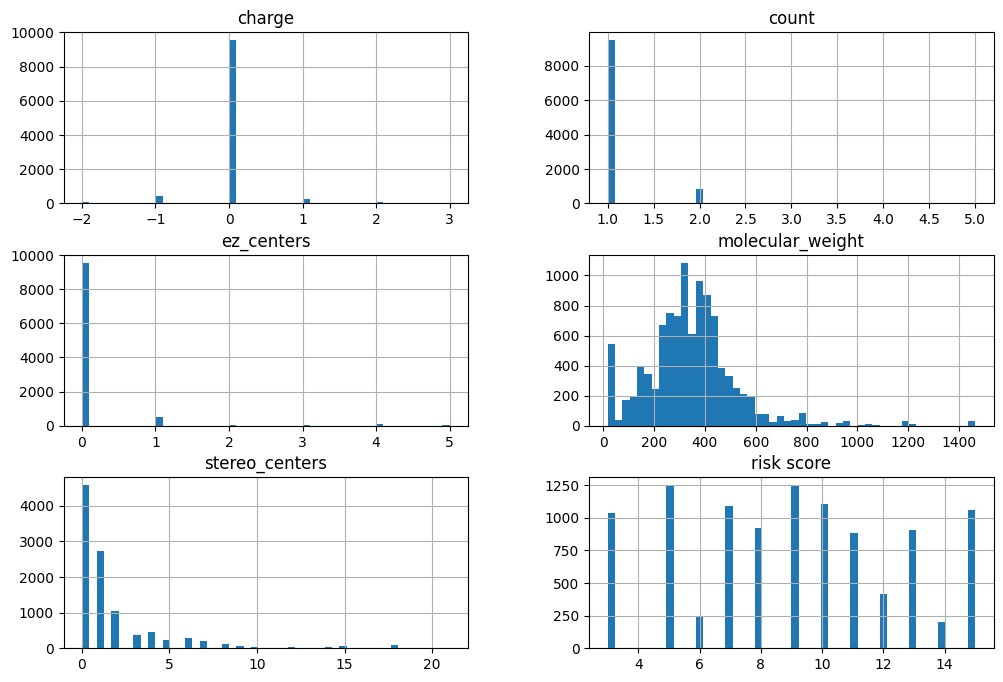

In [16]:
drugs_num=drugs.select_dtypes(include=[np.number])
drugs_num.hist(bins=50, figsize=(12,8))
plt.show()

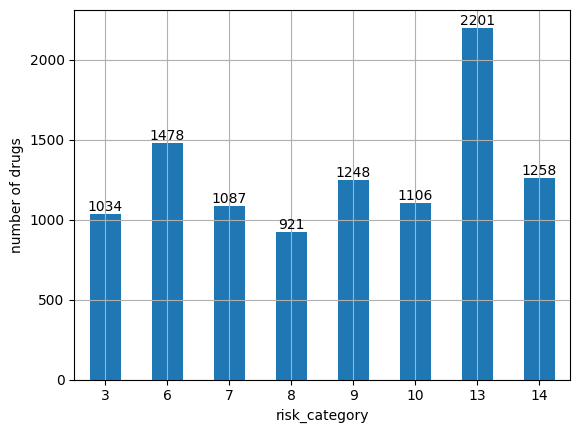

In [17]:
drugs['risk_cat']=pd.cut(drugs['risk score'],
                         bins=[0,3,6,7,8,9,10,13,np.inf],
                         labels=[3,6,7,8,9,10,13,14])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

risk_counts=drugs['risk_cat'].value_counts().sort_index()
ax=risk_counts.plot(kind='bar', rot=0, grid=True)
for i, v in enumerate(risk_counts):
    ax.text(i,v +0.1, str(v), ha='center', va='bottom')
plt.xlabel('risk_category')
plt.ylabel('number of drugs')
plt.show()

NOTE: ensure that all categories have >=2 entries, if not adapt the bins  
This is required for the stratified splitter

# 5. Train set, test set, validation set

## 5.1 Train set, test set

In [19]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(drugs, drugs['risk_cat']):
    strat_train_set=drugs.iloc[train_index]
    strat_test_set=drugs.iloc[test_index]

features=['UNII Codes for Inactive Ingredients',
          #'UNII Codes for Active Ingredients',
          #'charge',
          #'count',
          #'stereochemistry',
          #'ez_centers',
          'molecular_weight',
          #'optical_activity',
          #'stereo_centers',
          ]

target_feature='risk score'

X_train=strat_train_set[features]
y_train=strat_train_set[target_feature]
X_test=strat_test_set[features]
y_test=strat_test_set[target_feature]

In [20]:
print('X train shape = ', X_train.shape)
print('X test shape = ', X_test.shape)

X train shape =  (8266, 2)
X test shape =  (2067, 2)


# 6. Feature scaling and transformation

## 6.1 Custom transformers

In [21]:
class CustomMultilabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        #print("Fitting CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        self.mlb.fit(X)
        self.known_classes_ = set(self.mlb.classes_)
        print("Known classes:", self.known_classes_)
        return self

    def transform(self, X):
        #print("Transforming with CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        filtered_X = [
            [label for label in labels if label in self.known_classes_]
            for labels in X
        ]
        transformed_X = self.mlb.transform(filtered_X)
        #print("Transformed data:", transformed_X)
        return transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

    def _apply_eval(self, X):
        def safe_eval(x):
            try:
                result = x.split(', ') if isinstance(x, str) else x
                #print(f"Evaluating: {x} -> {result}")
                return result
            except Exception as e:
                #print(f"Error evaluating: {x} with error {e}")
                return []
        return [safe_eval(x) for x in X]


# NOTE: Un-comment the print checks only if needed for debugging/monitoring.
# With print statements require > 15GB RAM and cannot be saved (JSON string too long)

## 6.2 Pipelines and pre-processing

In [22]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

mlb_pipeline=make_pipeline(
    CustomMultilabelBinarizer())

num_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    StandardScaler())

log_pipeline=make_pipeline(
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cbrt_pipeline=make_pipeline(
    FunctionTransformer(np.cbrt, feature_names_out='one-to-one'),
    StandardScaler())

In [23]:
preprocessor=ColumnTransformer([
    #('1H_encoded', cat_pipeline,['stereochemistry','optical_activity']),
    #('numericals', num_pipeline,['charge', 'count','ez_centers']),
    ('log_feat', log_pipeline, ['molecular_weight']),
    #('cbrt_feat', cbrt_pipeline, ['stereo_centers']),
    ('mlb', CustomMultilabelBinarizer(), 'UNII Codes for Inactive Ingredients'),
    #('ord_enc',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['UNII Codes for Active Ingredients'])
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [24]:
pipeline.fit(X_train)

Known classes: {'GSY51O183C', 'PNR0YF693Y', 'RCZ785HI7S', '0E53J927NA', 'DK6Y9P42IN', 'R12CBM0EIZ', 'U3JF91U133', 'SA1B764746', 'C9H2L21V7U', '15F1B5K9A5', 'A2M91M918C', '4ERD2076EF', 'VM7F0B23ZI', '10LGE70FSU', '150CTM9A3J', '3K9958V90M', 'Y4S76JWI15', 'D9OM4SK49P', 'I38ZP9992A', 'KO5GYV0DCB', '1IVH67816N', '1699G8679Z', '8KW3E207O2', 'Q662QK8M3B', 'R75537T0T4', 'ND2M416302', 'H3R47K3TBD', '2944357O2O', 'LF3LEI45OH', '161H3B14U2', 'UTY7PDF93L', 'JL4CCU7I1G', 'H3UP11403C', '817L1N4CKP', '9XTM81VK2B', 'Q74T35078H', '5K3991GVWI', '3SY5LH9PMK', '905HNO1SIH', '1VPU26JZZ4', 'UKE75GEA7F', 'T5L8T28FGP', '7FLD91C86K', '2DMT128M1S', 'H0G9379FGK', '59RSS63D8J', 'I753WB2F1M', 'O03S90U1F2', 'R0ZB2556P8', 'J9EQA3S2JM', 'WL0328HX19', '15FIX9V2JP', '8A6OMU3I8L', 'CQ3XH3DET6', 'BUC5I9595W', '9B9691B2N9', 'XF417D3PSL', 'B1QE5P712K', '23ZQ42JZZH', 'V95R5KMY2B', '68538UP9SE', 'RS7A450LGA', 'MD83SFE959', '33X04XA5AT', '7LVU907546', 'SE337SVY37', '1Q73Q2JULR', 'P2OM2Q86BI', 'NZ94SDL6WR', '4ELV7Z65AP', '6HG

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_feat',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['molecular_weight']),
                                                 ('mlb',
                                                  CustomMultilabelBinarizer(),
                                                  'UNII Codes for Inactive '
                                                  'Ingredients')]))])

In [25]:
X_train_preprocessed = pipeline.transform(X_train)

In [26]:
X_test_preprocessed = pipeline.transform(X_test)

In [27]:
print('Train set shape= ', X_train_preprocessed.shape)
print('Test set shape= ', X_test_preprocessed.shape)

Train set shape=  (8266, 426)
Test set shape=  (2067, 426)


In [28]:
df_X_train_preprocessed=pd.DataFrame(X_train_preprocessed,
                                     columns=preprocessor.get_feature_names_out(),
                                     index=X_train.index)

df_X_test_preprocessed=pd.DataFrame(X_test_preprocessed,
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_test.index)

In [29]:
df_X_train_preprocessed.head(5)

,log_feat__molecular_weight,mlb__029TFK992N,mlb__02F3473H9O,mlb__059QF0KO0R,mlb__05JZI7B19X,mlb__06XEA2VD56,mlb__07XHK4SAV6,mlb__0A7M0N7SPE,mlb__0BZ5A00FQU,mlb__0E53J927NA,...,mlb__Z0H242BBR1,mlb__Z4152N8IUI,mlb__Z78RG6M2N2,mlb__Z82Y2C65EA,mlb__Z8IX2SC1OH,mlb__Z944H5SN0H,mlb__ZF94AP8MEY,mlb__ZK64F7XSTX,mlb__ZT934N0X4W,mlb__ZYD53NBL45
1358037,0.599878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4023092,0.323513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4607745,-3.008324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1231321,1.065470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807981,0.576984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
y_train.describe()

count    8266.000000
mean        9.011493
std         3.553717
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: risk score, dtype: float64

In [31]:
y_test.describe()

count    2067.000000
mean        9.002903
std         3.548583
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: risk score, dtype: float64

# 7. Unsupervised learning

## 7.1 t-SNE

### 7.1.1 t-SNE only

In [ ]:
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1500, random_state=42, n_jobs=-1, verbose=1)

In [ ]:
# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")

Number of available CPU cores: 4


In [ ]:
X_tsne=tsne.fit_transform(X_train_preprocessed)

/home/lara/Documents/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8266 samples in 0.005s...


[t-SNE] Computed neighbors for 8266 samples in 1.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8266
[t-SNE] Computed conditional probabilities for sample 2000 / 8266
[t-SNE] Computed conditional probabilities for sample 3000 / 8266
[t-SNE] Computed conditional probabilities for sample 4000 / 8266
[t-SNE] Computed conditional probabilities for sample 5000 / 8266
[t-SNE] Computed conditional probabilities for sample 6000 / 8266
[t-SNE] Computed conditional probabilities for sample 7000 / 8266
[t-SNE] Computed conditional probabilities for sample 8000 / 8266
[t-SNE] Computed conditional probabilities for sample 8266 / 8266
[t-SNE] Mean sigma: 1.269641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.710686
[t-SNE] KL divergence after 1500 iterations: -0.192520


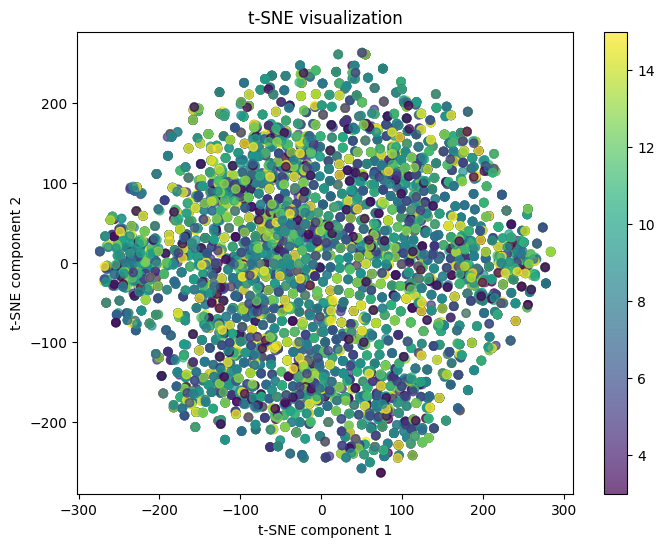

In [ ]:
t_SNE_only=plt.figure(figsize=(8, 6))
t_SNE_only_ax = t_SNE_only.add_subplot(111)
scatter_tsne = t_SNE_only_ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.get_cmap('viridis'), alpha=0.7)
t_SNE_only.colorbar(scatter_tsne)
t_SNE_only_ax.set_title('t-SNE visualization')
t_SNE_only_ax.set_xlabel('t-SNE component 1')
t_SNE_only_ax.set_ylabel('t-SNE component 2')
#t_SNE_only=plt.savefig('pictures/240624_t_sne_only.png')
plt.show()

The color gradient from purple (low risk) to yellow (high risk) represents the risk score of the drugs. Higher risk scores indicate drugs with more serious or adverse events. Being the features the encoded inactive ingredients, if there are noticeable clusters of similar colors, this suggests that certain combinations of inactive ingredients might be associated with higher or lower risk scores.  

The distribution of points can give insights into how inactive ingredients might contribute to the overall risk. Drugs with similar inactive ingredients (and thus similar binary features) tend to be closer together.

The overall circular pattern suggests a diverse dataset where no single group of inactive ingredients overwhelmingly dominates the risk score landscape.

#### 7.1.1.1 DBSCAN on t-SNE only results

In [ ]:
tsne_data = pd.DataFrame({
    'tsne1': X_tsne[:, 0],
    'tsne2': X_tsne[:, 1],
    'risk_score': y_train
})

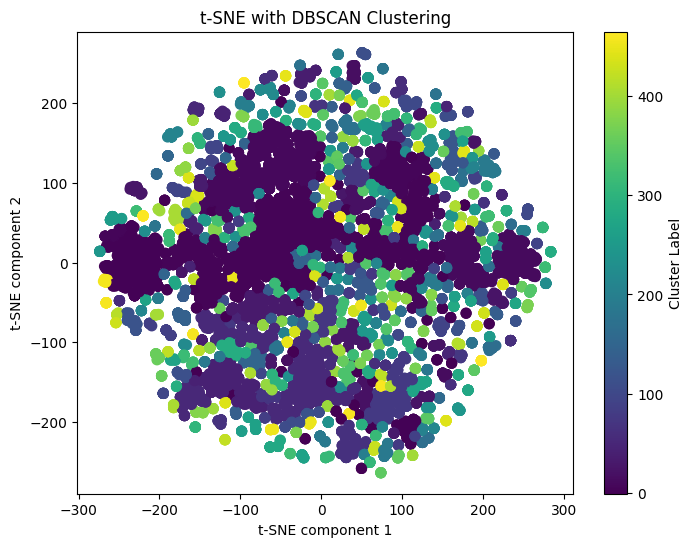

In [ ]:
dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(tsne_data[['tsne1', 'tsne2']])

tsne_data['cluster'] = clusters

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE with DBSCAN Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.savefig('pictures/240624_tsne_only_DBSCAN.png')
plt.show()


DBSCAN clustering is applied on the t-SNE visualization. Each color represents a different cluster label assigned by DBSCAN. Points with the same color belong to the same cluster.

The dark purple points (label 0) are classified as noise by DBSCAN. These points do not fit well into any cluster based on the `eps` and `min_samples` parameters. Areas with distinct colors (other than purple) indicate clusters of points that are close to each other in the high-dimensional space. The presence of multiple clusters suggests significant groupings within the data, potentially highlighting combinations of inactive ingredients associated with different risk scores.

Silhouette Score: 0.1945531815290451


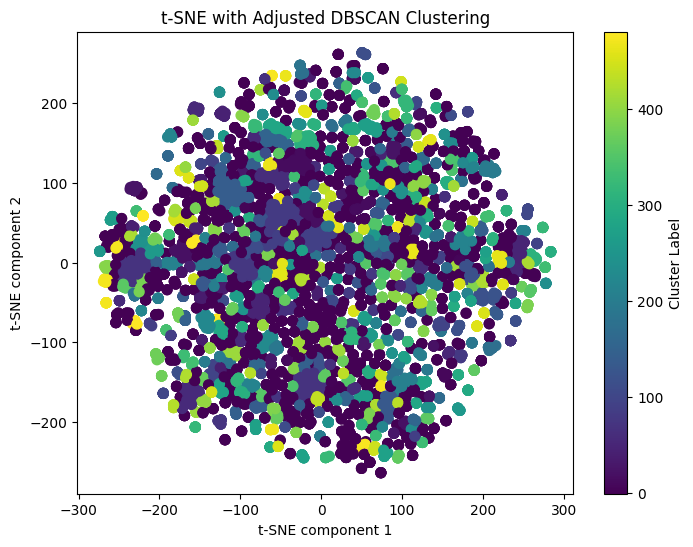

In [ ]:
dbscan = DBSCAN(eps=7, min_samples=8)
clusters = dbscan.fit_predict(tsne_data[['tsne1', 'tsne2']])
tsne_data['cluster'] = clusters

sil_score = silhouette_score(tsne_data[['tsne1', 'tsne2']], tsne_data['cluster'])
print(f'Silhouette Score: {sil_score}')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE with Adjusted DBSCAN Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
#plt.savefig('pictures/240624_tsne_only_DBSCAN_adj.png')
plt.show()


A low silhouette score indicates that the clustering is poor and that many points may be incorrectly assigned to clusters or marked as noise. This suggests that the current DBSCAN parameters may not be suitable for the data.

#### 7.1.1.2 K-means on t-SNE results

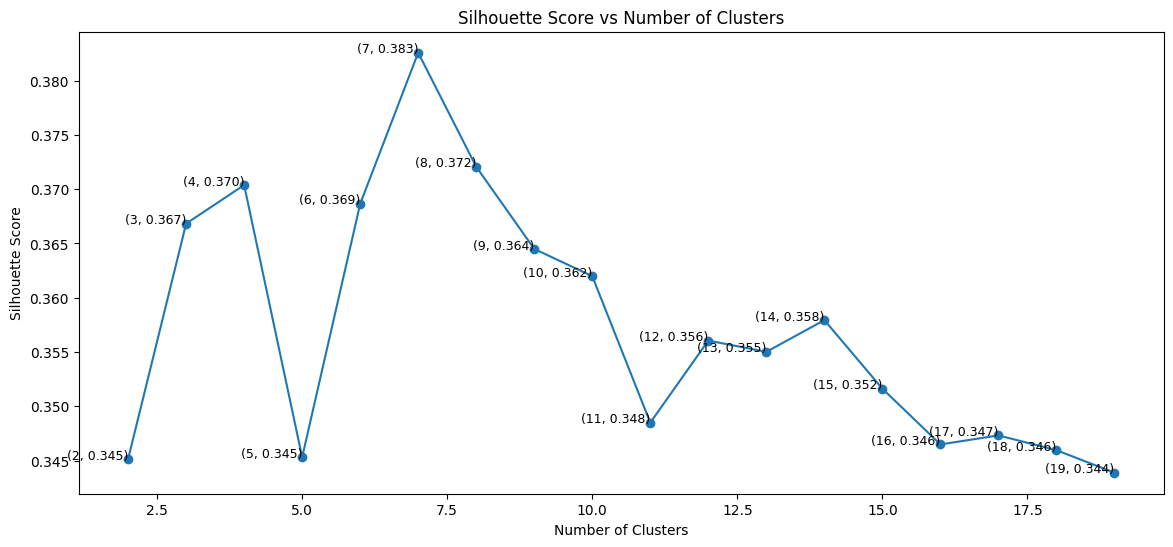

In [ ]:
sil_scores = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42 )
    kmeans_clusters = kmeans.fit_predict(tsne_data[['tsne1', 'tsne2']])
    sil_score = silhouette_score(tsne_data[['tsne1', 'tsne2']], kmeans_clusters)
    sil_scores.append(sil_score)

plt.figure(figsize=(14, 6))
plt.plot(k_range, sil_scores, marker='o')

for i, score in enumerate(sil_scores):
    plt.text(k_range[i], score, f'({k_range[i]}, {score:.3f})', fontsize=9, ha='right')

# Plot the silhouette scores for different numbers of clusters
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.savefig('pictures/240624_silh_score.png')
plt.show()

7 is the best number of clusters for an higher silhouette score

Silhouette Score for K-Means: 0.38256388902664185


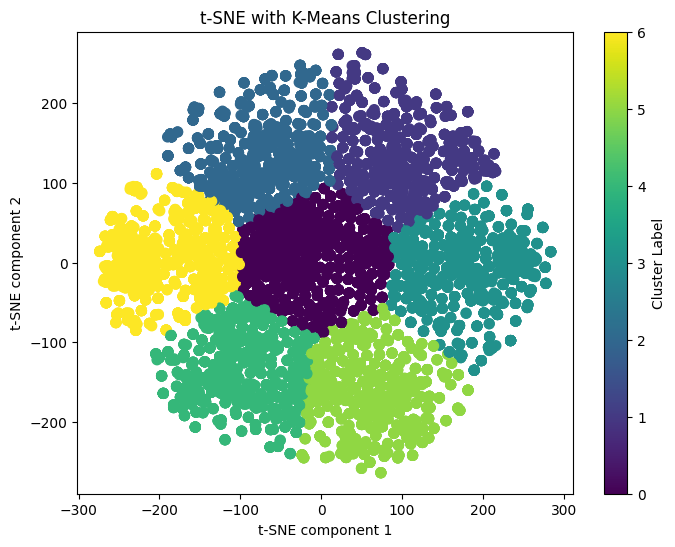

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_clusters = kmeans.fit_predict(tsne_data[['tsne1', 'tsne2']])
tsne_data['kmeans_cluster'] = kmeans_clusters

sil_score_kmeans = silhouette_score(tsne_data[['tsne1', 'tsne2']], tsne_data['kmeans_cluster'])
print(f'Silhouette Score for K-Means: {sil_score_kmeans}')

plt.figure(figsize=(8, 6))
scatter_kmeans = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['kmeans_cluster'], cmap='viridis', s=50)
plt.colorbar(scatter_kmeans, label='Cluster Label')
plt.title('t-SNE with K-Means Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.savefig('pictures/240624_tsne_only_kmeans.png')
plt.show()


The plot shows 7 distinct clusters, each represented by a different color.
Each color represents a different cluster, indicating that the drugs have been grouped into categories based on the similarity of their features (inactive ingredients). These clusters might help in identifying patterns or common characteristics among drugs within the same cluster.

#### 7.1.1.3 Analyze the obtained k-means clusters

   Cluster  Mean Risk Score  Std Risk Score  Count
0        0         9.094666        3.550503   1331
1        1         9.016750        3.533300   1194
2        2         9.000871        3.589314   1148
3        3         9.111728        3.575319   1262
4        4         8.913358        3.511715   1108
5        5         9.024597        3.554844   1179
6        6         8.879311        3.561915   1044


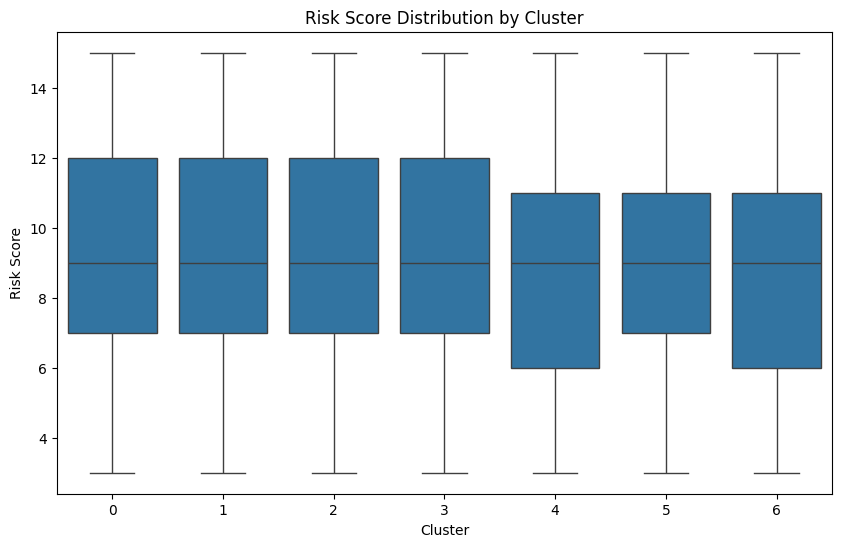

In [ ]:
cluster_summary = tsne_data.groupby('kmeans_cluster').agg({
    'risk_score': ['mean', 'std', 'count']
}).reset_index()

cluster_summary.columns = ['Cluster', 'Mean Risk Score', 'Std Risk Score', 'Count']
print(cluster_summary)

plt.figure(figsize=(10, 6))
sns.boxplot(x='kmeans_cluster', y='risk_score', data=tsne_data)
plt.title('Risk Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Risk Score')
plt.savefig('pictures/240624_tsne_only_riskdist_cluster.png')
plt.show()


The boxplot of risk score distribution by cluster provides some insights into how risk scores vary across different clusters. The median risk score is similar across all clusters, around the 8-10 range. Cluster 4 and 6 appears to have a slightly lower median risk score compared to other clusters.
All clusters have a similar overall range of risk scores: this suggests that while there are distinct clusters based on inactive ingredients, the risk scores are broadly similar across these clusters.

#### 7.1.1.4 Analysis of the feature contribution: centroids

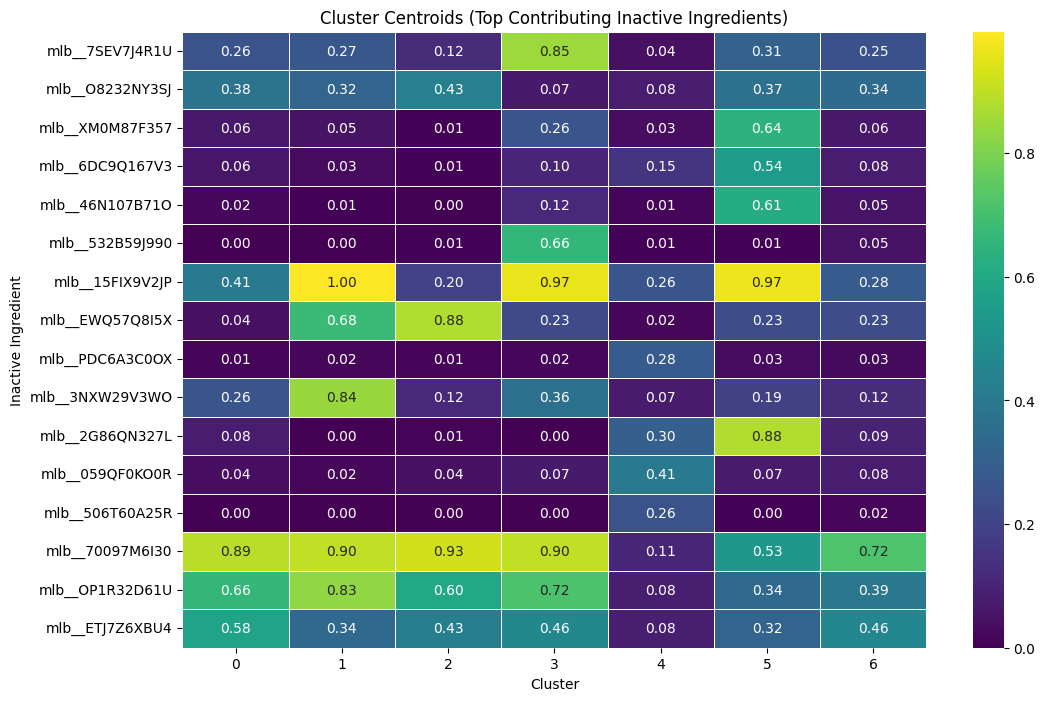

In [ ]:
df_X_train_preprocessed.index = tsne_data.index
merged_data = df_X_train_preprocessed.join(tsne_data[['tsne1', 'tsne2', 'risk_score', 'kmeans_cluster']])

inactive_ingredients = [col for col in df_X_train_preprocessed.columns if col.startswith('mlb_')]
centroids = merged_data.groupby('kmeans_cluster')[inactive_ingredients].mean()
top_features_per_cluster = centroids.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
top_features = list(set([item for sublist in top_features_per_cluster for item in sublist]))
top_centroids = centroids[top_features]


plt.figure(figsize=(12, 8))
sns.heatmap(top_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
plt.savefig('pictures/240624_tsne_centroid_heatmap.png')
plt.show()

Each row represents an inactive ingredient. The values in the heatmap indicate the mean presence (0 to 1) of the inactive ingredient in the drugs of each cluster. Each column represents a cluster identified by K-Means clustering. Clusters are shown in their original order. The value of each cell indicates the mean presence of the corresponding inactive ingredient in that cluster. Higher values (closer to 1) indicate a higher presence of the ingredient in that cluster, while lower values (closer to 0) indicate a lower presence.  

Cluster-Specific Ingredients are clusters with high mean values for certain ingredients. Common Ingredients Across Cluster are instead ingredients with consistently high or low values across multiple clusters that might be common or rare across the dataset.
Unique Cluster Characteristics are unique ingredients that differentiate clusters them from others.

By the analysis of the heatmap obtained, Cluster 1 is highly characterized by mlb__15FIX9V2JP (TITANIUM DIOXIDE), which has a value of 1.00.  Cluster 5 is characterized by high values for mlb__15FIX9V2JP (TITANIUM DIOXIDE) and mlb__2G86QN327L (GELATIN), common excipients of capsules product. Cluster 3 has high values for mlb__15FIX9V2JP (TITANIUM DIOXIDE), mlb__7SEV7J4R1U (TALC, unique cluster characteristic) and mlb__70097M6I30 (MAGNESIUM STEARATE) common excipients for tablets instead. As also observed by EDA, TITANIUM DIOXIDE is a common ingredientfor many formulation type.
Ingredients like mlb__PDC6A3COOX (GLYCERIN) and mlb__506T60A25R (SORBITOL), both sweeteners, have generally low values across all clusters, indicating they are rarely present. Ingredients like mlb__70097M6I30 (MAGNESIUM STEARATE) and mlb__OP1R32D61U (CELLULOSE MICROCRISTALLINE) show significant presence in multiple clusters, indicating they are more common, in agreemenet with the observations from EDA.

#### 7.1.1.5 Hyerarchical clustering on the centroids

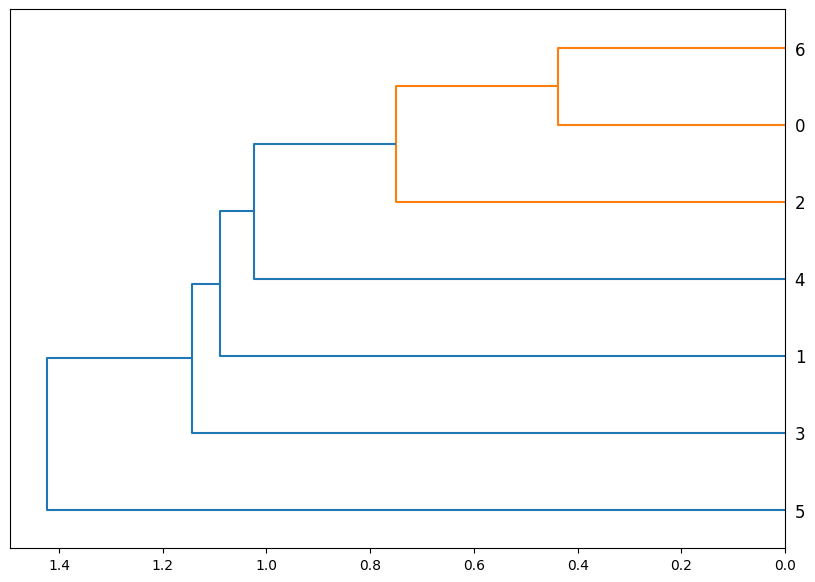

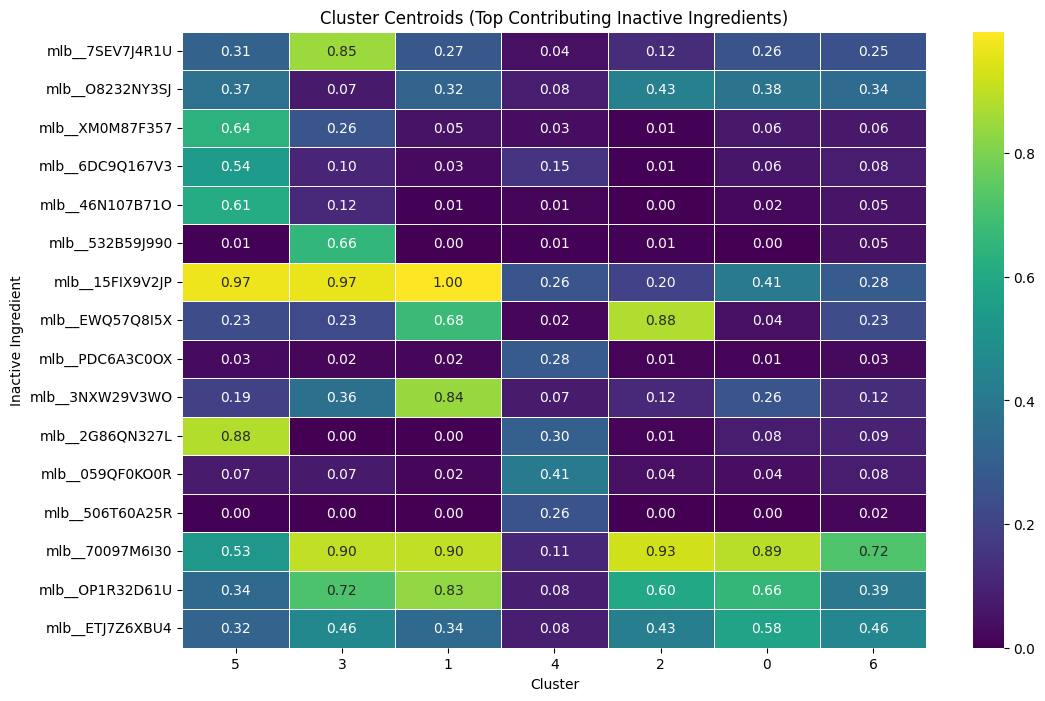

In [ ]:
linked = linkage(top_centroids, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=top_centroids.index, orientation='left')
#plt.savefig('pictures/240624_tsne_dendogram.png')
plt.show()

top_centroids = top_centroids.iloc[dendrogram(linked, no_plot=True)['leaves']]

plt.figure(figsize=(12, 8))
sns.heatmap(top_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
#plt.savefig('pictures/240624_tsne_hyerarc_heatmap.png')
plt.show()


**Dendrogram**:   

The dendrogram shows the hierarchical relationships among the clusters. The horizontal axis represents the different clusters, and the vertical axis represents the distance or dissimilarity at which clusters are merged. Clusters that merge at lower heights are more similar.
Clusters 6 and 0 are very similar, as they merge at a relatively low distance. Clusters 2, 4, 1, and 3 also show varying degrees of similarity, merging at different heights.

**Heatmap**:

Cluster 0 has high presence of mlb__ETJ7Z6XBU4 (SILICON DIOXIDE) and mlb__EWQ57Q8I5X (LACTOSE MONOHYDRATE) typical excipients for tablets. Cluster 1 is characterized by mlb__3NXW29V3WO (HYPROMELLOSE), typical excipient for release-controlled drugs, with a high presence of 0.84. Cluster 2 is characterized by mlb_EWQ57Q8I5X (LACTOSE MONOHYDRATE), a bulking agent, with a notable presence of 0.88.  Cluster 3 is notable for mlb__7SEV7J4R1U (TALC), glidant to improve powder flow in tablet compression,  with a mean presence of 0.85. Cluster 4 has high presence of mlb__70097M6I30 (MAGNESIUM STEARATE) and mlb__OP1R32D61U (MICROCRYSTALLINE CELLULOSE). Cluster 5 is highly characterized by mlb__15FIX9V2JP (TITANIUM DIOXIDE), with a mean presence of 1.00. Also has a high presence of mlb__6DC9Q167V3 (PROPYLENE GLYCOL), a drug solubilizer, indicating drugs that require a cosolvent with water and common i.e. in soft capsules, confirming findings from the previous heatmap. Cluster 6 is characterized by a significant presence of mlb__EWQ57Q8I5X (LACTOSE MONOHYDRATE).

Rare and common ingredients follow the same distribution as the previous heatmap.
Some clusters share common ingredients, suggesting possible similarities in the formulation or characteristics of drugs in those clusters. Clusters 6 and 0 share similar profiles, indicating that they have comparable inactive ingredient compositions, both containing predominantely tablets from the common ingredients analysis.
Clusters 1 and 3 have distinct profiles, with high values for specific ingredients like HYPROMELLOSE and TALC, respectively, indicating two different formulation type: release-controlled and capsules/tables with clumping and sticking propensity.

#### 7.1.1.6 Hyerarchical clustering on columns and rows

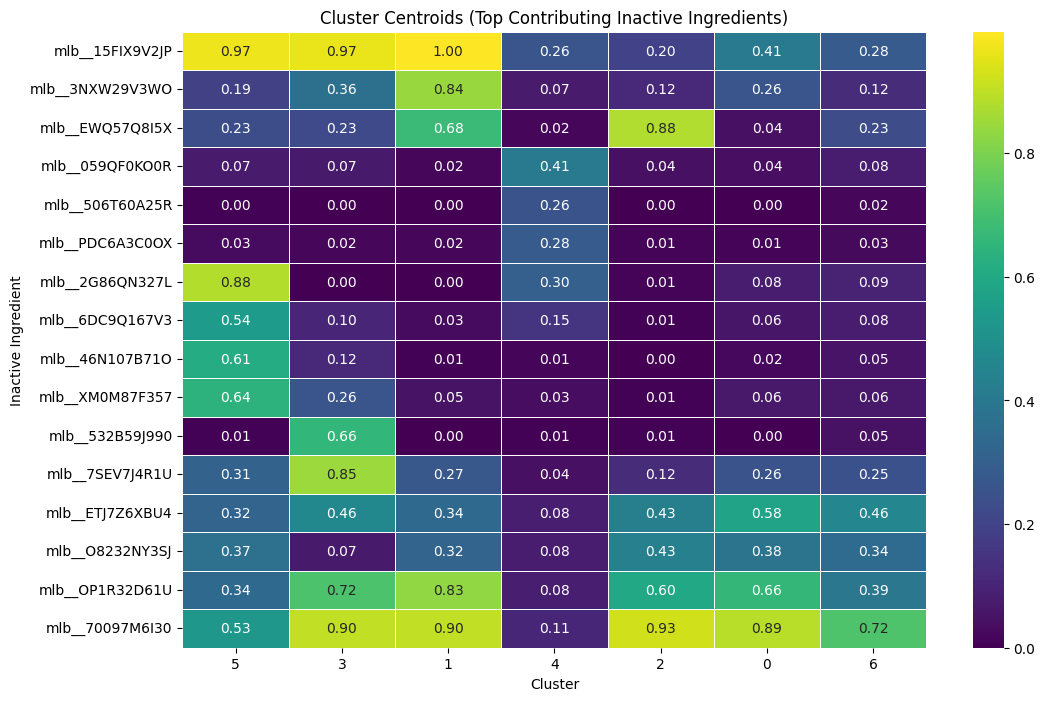

In [ ]:
linked_rows = linkage(top_centroids, 'single')
linked_cols = linkage(top_centroids.T, 'single')
dendro_rows = dendrogram(linked_rows, no_plot=True)
dendro_cols = dendrogram(linked_cols, no_plot=True)
reordered_centroids = top_centroids.iloc[dendro_rows['leaves'], :].iloc[:, dendro_cols['leaves']]

plt.figure(figsize=(12, 8))
sns.heatmap(reordered_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
plt.savefig('pictures/240624_tsne_2x_hyer_heatmap.png')
plt.show()


This heatmap shows the cluster centroids for the top contributing inactive ingredients, with both rows (inactive ingredients) and columns (clusters) reordered based on hierarchical clustering. Distribution and key findings are comparable with the discussion above.

### 7.1.2 t-SNE on PCA output

In [ ]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_train_preprocessed)
X_tsne = tsne.fit_transform(pca_result)

/home/lara/Documents/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8266 samples in 0.001s...
[t-SNE] Computed neighbors for 8266 samples in 0.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8266
[t-SNE] Computed conditional probabilities for sample 2000 / 8266
[t-SNE] Computed conditional probabilities for sample 3000 / 8266
[t-SNE] Computed conditional probabilities for sample 4000 / 8266
[t-SNE] Computed conditional probabilities for sample 5000 / 8266
[t-SNE] Computed conditional probabilities for sample 6000 / 8266
[t-SNE] Computed conditional probabilities for sample 7000 / 8266
[t-SNE] Computed conditional probabilities for sample 8000 / 8266
[t-SNE] Computed conditional probabilities for sample 8266 / 8266
[t-SNE] Mean sigma: 1.073006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.335220
[t-SNE] KL divergence after 1500 iterations: -0.195073


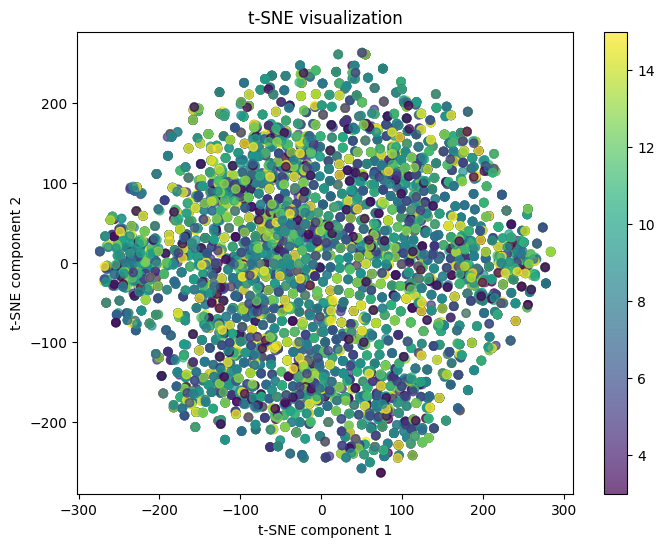

In [ ]:
labels=y_train
pca_tsne=plt.figure(figsize=(8, 6))
pca_tsne_ax=pca_tsne.add_subplot(111)
scatter_pca_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.get_cmap('viridis'), alpha=0.7)
pca_tsne.colorbar(scatter_pca_tsne)
pca_tsne_ax.set_title('t-SNE visualization')
pca_tsne_ax.set_xlabel('t-SNE component 1')
pca_tsne_ax.set_ylabel('t-SNE component 2')
pca_tsne=plt.savefig('pictures/240624_pca_tsne.png')
plt.show()

The updated t-SNE visualization after applying PCA dimensionality reduction shows a similar structure to the initial visualization.
The overall circular pattern suggests a diverse dataset where no single group of inactive ingredients overwhelmingly dominates the risk score landscape. The overall continuous, circular pattern is preserved, indicating that the essential relationships and variations in the data are maintained even after applying PCA. This suggests PCA successfully retained the most significant features of the data before t-SNE was applied.

As the pattern is very similar to the previous, no further cluster analysis will be perfomed.


#### 7.1.2.1 Comparison

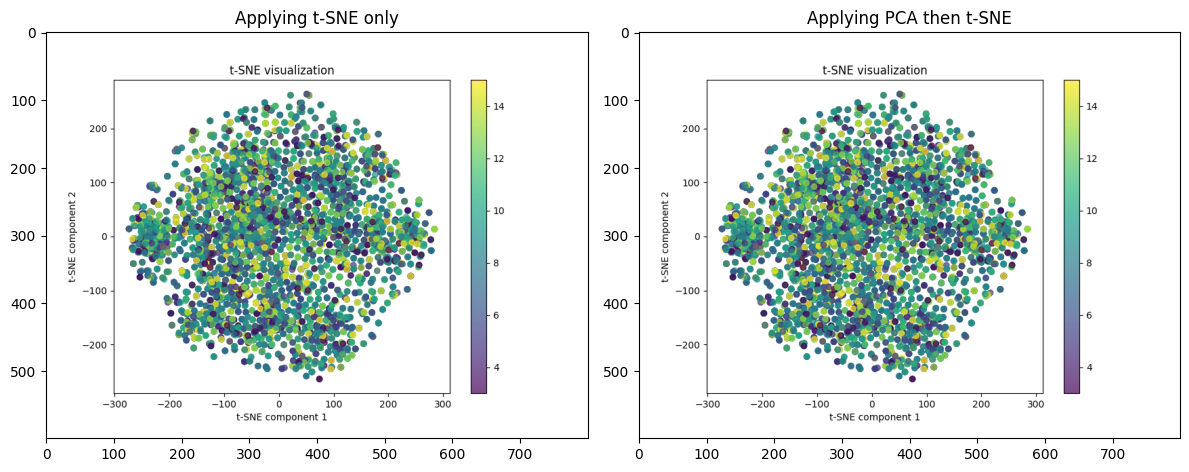

In [ ]:
t_SNE_only=np.asarray(Image.open('pictures/240624_t_sne_only.png'))
pca_tsne=np.asarray(Image.open('pictures/240624_pca_tsne.png'))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].imshow(t_SNE_only)
axs[0].set_title('Applying t-SNE only')

axs[1].imshow(pca_tsne)
axs[1].set_title('Applying PCA then t-SNE')

plt.tight_layout()
plt.savefig('pictures/240624_comparison.png')
plt.show()


If the data is very high-dimensional, like in the dataset evaluated, PCA could potentially help to preprocess the data, making t-SNE more effective. As both plots look quite similar, t-SNE alone was sufficient to capture the essential structure

## 7.2 LLE

In [ ]:
lle=LocallyLinearEmbedding(n_components=2,eigen_solver='dense', n_neighbors=10,n_jobs=1, random_state=42)
X_llembedded=lle.fit_transform(X_train_preprocessed)

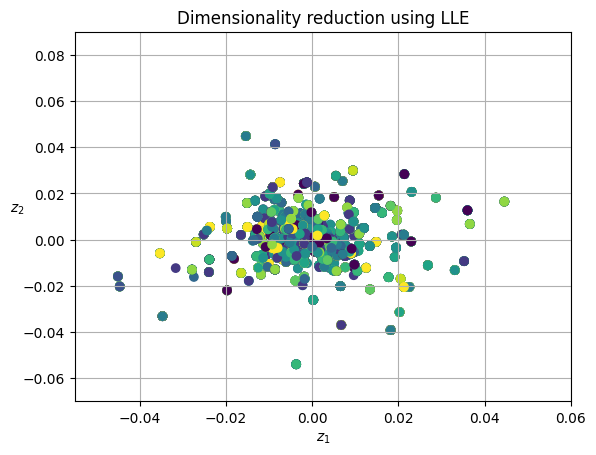

In [ ]:
plt.scatter(X_llembedded[:, 0], X_llembedded[:, 1],
            c=y_train, cmap='viridis')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.savefig('pictures/240624_lle.png')
plt.title("Dimensionality reduction using LLE")
plt.show()

LLE (Locally Linear Embedding) shows weaker performance when compared to the t-SNE application above, this is in line with the weknesses of LLE highlighted by by Van der Maaten and Hinton in their paper (Visualizing data using t-SNE, Journal of Machine Learning Research 9,2008, 2579-2605), when handling highly dimensional datasets with many subsets.  

## 7.3 Unsupervised learning conclusions
The k-means clustering applied on the t-SNE results, and the subsequent analysis of the clusters, allowed to successfully divide the drugs in different groups basing on the inactive ingredients. The interpretation of the main clusters ingredients and their combination indicates different type of oral formulation for the different clusters successfully separated just using the encoded ingredients. The analysis provides valuable insights into which inactive ingredients are commonly used together and which are unique to certain clusters. This information can be useful for understanding formulation practices and potentially for regulatory or quality control purposes.

The box plots of risk score distributions show that there is no significant difference in risk scores among the clusters. The median and spread of risk scores are fairly similar across all clusters, suggesting that the combination of inactive ingredients alone, does not lead to a substantial difference in risk scores.

Other clustering techniques, as well as the application of dimensionality reduction with PCA or LLE did not provided additional benefit.

Since the risk scores do not vary significantly across the clusters, it may be beneficial to include other features in the clustering process. Concentrations, dosage forms, therapeutic classes, or other relevant data might provide additional differentiation and insights into the factors driving risk scores. This further analysis is not in scope for the current project.

# 8. Supervised learning

## 8.1 Ensemble learning

In [ ]:
rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                               n_jobs=-1, random_state=42, verbose=1)

In [ ]:
rnd_clf.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.4s finished


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42, verbose=1)

In [ ]:
y_train_pred_rf=cross_val_predict(rnd_clf, X_train_preprocessed, y_train, cv=10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent w

In [ ]:
for score, name in zip(rnd_clf.feature_importances_, df_X_train_preprocessed.columns):
    print(f"{round(score, 2)}: {name}")

0.06: log_feat__molecular_weight
0.0: mlb__029TFK992N
0.0: mlb__02F3473H9O
0.01: mlb__059QF0KO0R
0.0: mlb__05JZI7B19X
0.0: mlb__06XEA2VD56
0.0: mlb__07XHK4SAV6
0.0: mlb__0A7M0N7SPE
0.0: mlb__0BZ5A00FQU
0.0: mlb__0E53J927NA
0.0: mlb__0HO1H52958
0.0: mlb__0I3V7S25AW
0.0: mlb__0IRH2BR587
0.0: mlb__0MKJ04EU89
0.0: mlb__0UZA3422Q4
0.0: mlb__0VUT3PMY82
0.0: mlb__0WZ8WG20P6
0.0: mlb__0ZBX0N59RZ
0.0: mlb__10LGE70FSU
0.0: mlb__11628IH70O
0.0: mlb__1364PS73AF
0.0: mlb__14255EXE39
0.0: mlb__150CTM9A3J
0.0: mlb__15F1B5K9A5
0.01: mlb__15FIX9V2JP
0.0: mlb__161H3B14U2
0.0: mlb__1678RKX8RT
0.0: mlb__1699G8679Z
0.0: mlb__196OC77688
0.0: mlb__1CS02G8656
0.0: mlb__1DI56QDM62
0.0: mlb__1I96OHX6EK
0.01: mlb__1IVH67816N
0.01: mlb__1K09F3G675
0.0: mlb__1P9D0Z171K
0.01: mlb__1Q73Q2JULR
0.0: mlb__1T6N4D9YV6
0.0: mlb__1VPU26JZZ4
0.0: mlb__1Z74184RGV
0.0: mlb__2126FD486L
0.01: mlb__2165RE0K14
0.0: mlb__21C2F5E8RE
0.0: mlb__22ADO53M6F
0.0: mlb__230OU9XXE4
0.0: mlb__23OV73Q5G9
0.0: mlb__23ZQ42JZZH
0.0: mlb__241ATL

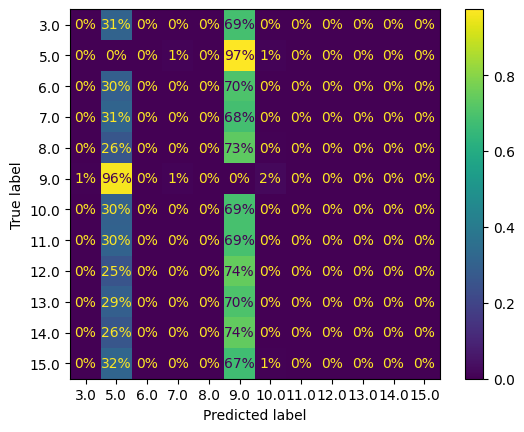

In [ ]:
sample_weight=(y_train_pred_rf != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format=".0%")
plt.show()

From the confusion matrix and the feature importance there is no feature that affect the classification in a relevant manner, the confusion matrix shows many drugs misclassified in the wrong class.

Labels 9, 10, and 11 (the most common from the boxplot above) show high accuracy with values 69%, 97%, and 73% respectively.There are significant misclassifications for labels 3 and 6, where a high percentage of true label 3 is predicted as label 9 (69%), and label 6 is distributed among labels 5 and 9. The model struggles with differentiating between certain classes, as indicated by the spread of percentages in the off-diagonal cells.

This is in line with the findings from the unsupervised learning, that inactive ingredients alone are not sufficient to predict the risk score, indicating that there isn't a clear relationship between their pattent and the belonging to a particular risk class.

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_leaf_nodes': [10, 16, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train_preprocessed, y_train)
y_pred_opt = best_model.predict(X_train_preprocessed)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   7.5s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.2s
[CV] END max_depth=None, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.1s
[CV] END max_depth=None,

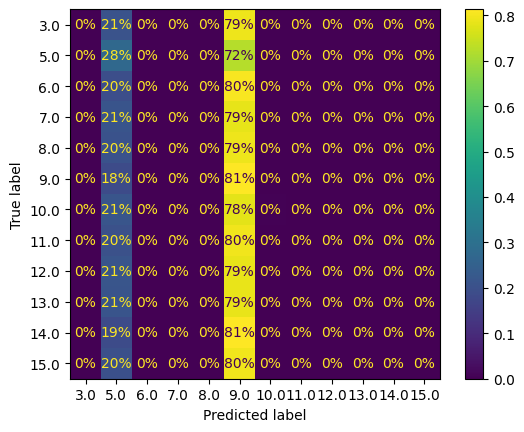

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_opt,
                                        normalize='true', values_format=".0%")
plt.show()

Also the improvement of the method by grid search and selection of the best model do not provide significant benefit, as expected from the previous unsupervised learning analysis.

## 8.2 Stacking

Stacking leverages the strengths of multiple learning algorithms, potentially improving performance by combining models that make different types of errors. Useful for complex problems where no single model perform well, stacking can help by combining the strengths of multiple models. If the data is noisy or has a lot of variance,  as it was observed by DBSCAN cluster analysis on the t-SNE dimensionality reduced data, stacking can help by smoothing out individual model errors.

In [ ]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)
stacking_clf.fit(X_train_preprocessed, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_leaf_nodes=10,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, g...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [ ]:
y_pred_train = stacking_clf.predict(X_train_preprocessed)

accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.023711589644326157
Confusion Matrix:
 [[ 22 140   0  90  91 105  94  69   0  86   0 130]
 [152  56   0 102 117 127 112  73   0  98   0 156]
 [ 23  33   0  15  22  17  17  17   0  19   0  26]
 [119 157   0  22  97  99  95  74   0  79   0 128]
 [102 126   0  79  15  91  83  65   0  71   0 105]
 [152 183   0 110 105  21 115  75   0  93   0 144]
 [128 151   0 101 106  97  19  72   0  81   0 130]
 [ 91 119   0  78  78  85  78   8   0  70   0  99]
 [ 42  46   0  30  28  31  34  27   0  29   0  52]
 [105 127   0  82  77  89  86  65   0   9   0  96]
 [ 25  23   0  14  13  19  18  15   0  15   0  19]
 [122 150   0  90  98 110  94  72   0  85   0  24]]


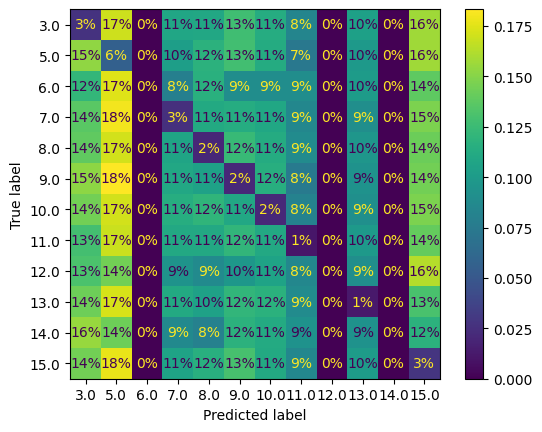

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

The stacking classifier had more dispersed misclassifications across various labels. The model seems to have difficulty differentiating between many of the classes, as indicated by the spread of values in the off-diagonal cells. Misclassifications are relatively uniformly distributed, with many cells showing values around 10-13%. This uniform spread suggests that the model might be struggling with overlapping feature spaces or the classes not being distinct enough. The diagonal percentages are lower and do not show clear dominance, which indicates the model's overall performance might not be strong for this dataset.

### 8.2.1 Test set

In [ ]:
y_pred_test = stacking_clf.predict(X_test_preprocessed)
accuracy = accuracy_score(y_test, y_pred_test)

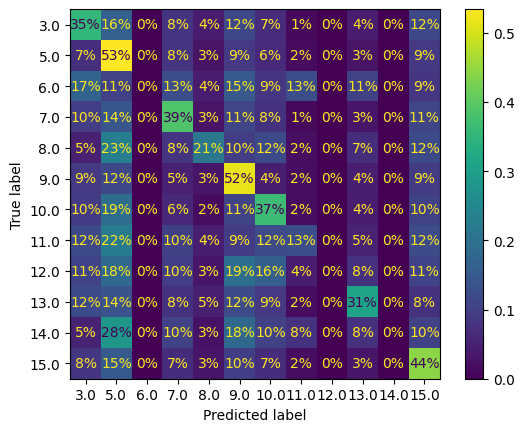

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        normalize='true', values_format=".0%")
plt.show()

Results on the test set are comparable with what observed for the training set.

## 8.3 Stacking on k-means clusters

In [ ]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred_clusters = kmeans.fit_predict(X_train_preprocessed)
X_train_with_clusters = np.hstack((X_train_preprocessed, y_pred_clusters.reshape(-1, 1)))

In [ ]:
# Base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Meta-model
meta_model = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)
stacking_clf.fit(X_train_with_clusters, y_train)
y_pred_train = stacking_clf.predict(X_train_with_clusters)


In [ ]:
# Evaluate the stacking classifier
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)

Accuracy: 0.02891362206629567


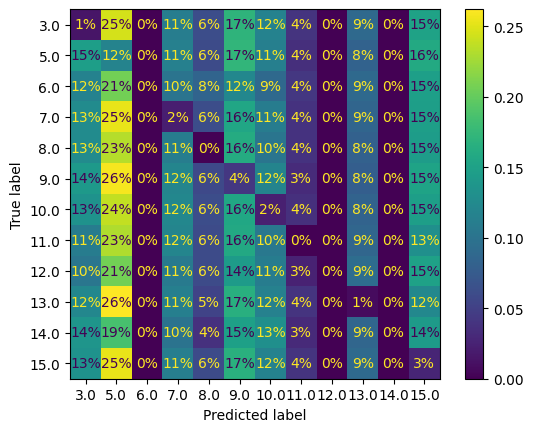

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

The combination of stacking with clustering (K-means, using the best number of clusters as inspected before), does not oprovide any significant benefit on the stacking alone, this is in line with the observations on the unsupervised learning. Also supervised learning confirms the absence of a clear relationship between the features (ingredients) and the risk score.

In [ ]:
# Test set
y_test_clusters = kmeans.predict(X_test_preprocessed)
X_test_with_clusters = np.hstack((X_test_preprocessed, y_test_clusters.reshape(-1, 1)))
y_pred_test = stacking_clf.predict(X_test_with_clusters)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.34252539912917274


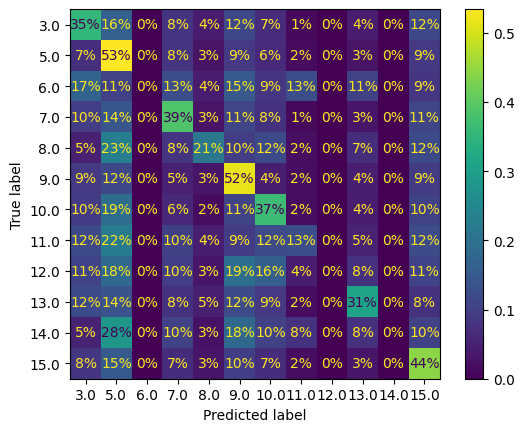

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        normalize='true', values_format=".0%")
plt.show()

The application of the stacking techniques on the clusters slightly increase the predictability for the test set (diagonal), the misclassification is anyway diffused for all classes confirming once more the conclusion from the previous models.

# 9. Neural Networks

As the dataset is formed by a long pattern of 1 or 0 depending wether the ingredient is present or not, a neural network could be a good approach to define wether exists a relationship between specific patterns and the target feature (risk score).
The present datasetis very small to allow a proper training of a neural network (only 10k rows), it is therefore expected as a result a low accuracy and loss. The structure will be nevertheless build for future development in the project, with a larger and more diversified dataset, not in scope for the current delivery.

## 9.1 Fully connected neural network

In [32]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

unique_labels_encoded = np.unique(y_train_encoded)
print("Unique labels after encoding in y_train:", unique_labels_encoded)

Unique labels after encoding in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [33]:
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_encoded, y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 0.8329302700523983, 1: 0.693689157435381, 2: 3.644620811287478, 3: 0.7917624521072797, 4: 0.9346449570330168, 5: 0.6902137608550434, 6: 0.7783427495291902, 7: 0.9756846081208688, 8: 2.159352142110763, 9: 0.9359148550724637, 10: 4.278467908902692, 11: 0.8151873767258383}


In [46]:
print("Unique labels in y_train_encoded:", np.unique(y_train_encoded))
print("Unique labels in y_test_encoded:", np.unique(y_test_encoded))
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

Unique labels in y_train_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
X_train_preprocessed shape: (8266, 426)
y_train_encoded shape: (8266,)
X_test_preprocessed shape: (2067, 426)
y_test_encoded shape: (2067,)


In [35]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(426,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               128100    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 12)                1212      
                                                                 
Total params: 159412 (622.70 KB)
Trainable params: 159412 (622.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [38]:
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=30,
                    validation_data=(X_test_preprocessed, y_test_encoded),
                    class_weight=class_weights_dict,
                    batch_size=128)

Epoch 1/30
65/65 [==============================] - 1s 7ms/step - loss: 2.4916 - accuracy: 0.0835 - val_loss: 2.4972 - val_accuracy: 0.0808
Epoch 2/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4902 - accuracy: 0.0840 - val_loss: 2.4962 - val_accuracy: 0.0769
Epoch 3/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4890 - accuracy: 0.0826 - val_loss: 2.4953 - val_accuracy: 0.0760
Epoch 4/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4880 - accuracy: 0.0819 - val_loss: 2.4946 - val_accuracy: 0.0750
Epoch 5/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4871 - accuracy: 0.0835 - val_loss: 2.4942 - val_accuracy: 0.0750
Epoch 6/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4863 - accuracy: 0.0809 - val_loss: 2.4938 - val_accuracy: 0.0755
Epoch 7/30
65/65 [==============================] - 0s 5ms/step - loss: 2.4855 - accuracy: 0.0826 - val_loss: 2.4935 - val_accuracy: 0.0735
Epoch 8/30
65/65 [==

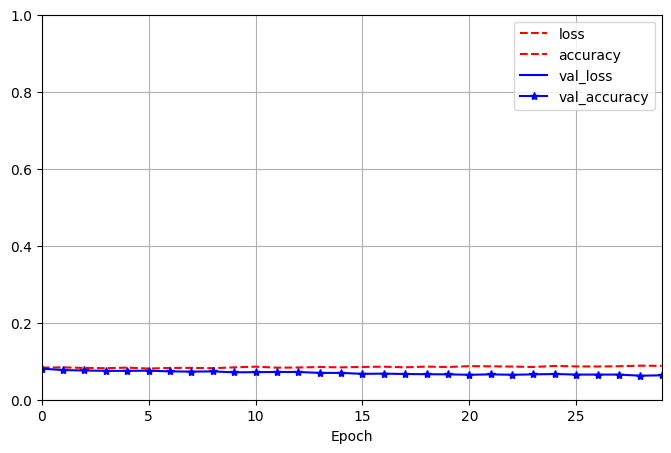

In [39]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

As expected, due to the low amount of data, the network does not train successfully.
Parameters may be tuned for a slightly better results and for use in future next steps.

## 9.2 Fully connected neural network with regularization and hyperparameter tuning

In [40]:
model_reg=tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_dim=X_train_preprocessed.shape[1], activation='relu',),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [41]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               54656     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 12)                396       
                                                                 
Total params: 65388 (255.42 KB)
Trainable params: 65388 (255.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
optimizer=Adam(learning_rate=0.001)
model_reg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [43]:
history_reg = model_reg.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=100,
    validation_data=(X_test_preprocessed, y_test_encoded),
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/100
33/33 [==============================] - 1s 10ms/step - loss: 2.4587 - accuracy: 0.1098 - val_loss: 2.4263 - val_accuracy: 0.1161
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 2.4089 - accuracy: 0.1204 - val_loss: 2.4011 - val_accuracy: 0.1118
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 2.3897 - accuracy: 0.1226 - val_loss: 2.3942 - val_accuracy: 0.1069
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 2.3802 - accuracy: 0.1224 - val_loss: 2.3936 - val_accuracy: 0.1069
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 2.3759 - accuracy: 0.1250 - val_loss: 2.3936 - val_accuracy: 0.1089
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 2.3724 - accuracy: 0.1247 - val_loss: 2.3949 - val_accuracy: 0.0997
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 2.3710 - accuracy: 0.1177 - val_loss: 2.3964 - val_accuracy: 0.0992
Epoch 8/100


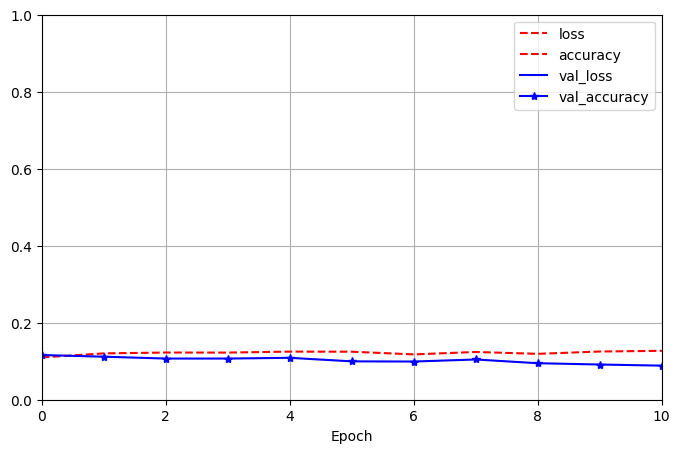

In [44]:
pd.DataFrame(history_reg.history).plot(
    figsize=(8,5), xlim=[0,10], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

Also with hyperparameter tuning, no significant better results were obtained. Accuracy and loss remins constant along the epochs indicating absence of training from the network.

# 10. Conclusions

The k-means clustering applied on the t-SNE results, and the subsequent analysis of the clusters, allowed to successfully divide the drugs in different groups basing on the inactive ingredients. The interpretation of the main clusters ingredients and their combination indicates different type of oral formulation for the different clusters successfully separated just using the encoded ingredients. The analysis provides valuable insights into which inactive ingredients are commonly used together and which are unique to certain clusters. This information can be useful for understanding formulation practices and potentially for regulatory or quality control purposes.

The box plots of risk score distributions show that there is no significant difference in risk scores among the clusters. The median and spread of risk scores are fairly similar across all clusters, suggesting that the combination of inactive ingredients alone, does not lead to a substantial difference in risk scores.

Other clustering techniques, as well as the application of dimensionality reduction with PCA or LLE did not provided additional benefit.

Since the risk scores do not vary significantly across the clusters, it may be beneficial to include other features in the clustering process. Concentrations, dosage forms, therapeutic classes, or other relevant data might provide additional differentiation and insights into the factors driving risk scores. This further analysis is not in scope for the current project.

Supervised learning analyses, including ensemble methods like Random Forest and complex approaches like stacking, confirmed the unsupervised learning conclusions. The confusion matrices reveal a weak relationship between inactive ingredients and risk scores, leading to significant misclassification of drugs.

Neural network application, despite its potential for binary pattern recognition, did not provide substantial benefits due to the limited and low-quality data.

In summary there is no clear relationship between inactive ingredient pattern and the propensity of a drug to prompt a severe adverse event, the choice of these ingredients can therefore primarily focus on the properties of active ingredients and the desired qualities of the final product without additional caution.
